In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from collections import OrderedDict

In [18]:
%reload_ext watermark
%watermark -a "Moon Jeong-Hyeon" -u -d -p numpy,pandas,matplotlib,sklearn

Author: Moon Jeong-Hyeon

Last updated: 2020-11-30

numpy     : 1.19.3
pandas    : 1.1.4
matplotlib: 3.3.3
sklearn   : 0.23.2



코드 참고 : deep learning from scratch

**NOTE** 코딩해야할 부분을 제외하고는 수정하지 마세요.

# DATA

tanh 함수 데이터

In [19]:
raw_x = np.arange(-10,10,0.001).reshape(-1,1)

raw_y = np.tanh(raw_x)

x_train = raw_x
y_train = raw_y

(20000, 1) (20000, 1)


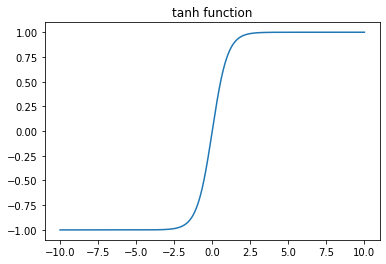

In [20]:
print(x_train.shape, y_train.shape)
plt.title("tanh function")
plt.plot(raw_x, raw_y)
plt.show()

# Layer

In [21]:
from sklearn.metrics import mean_squared_error
# 1-3 Mean Squared Error(Mse) 클래스 구현
class Mse:
    def __init__(self):
        self.loss = None # 손실률
        self.y = None # 실제값
        self.t = None # 목표값

    def forward(self, x, t):
        # 실제값과 목표값을 저장
        self.t = t
        self.y = x

        # mse 저장 및 반환
        # mse = sigma((y - t)^2) / n 이다
        self.loss = np.mean((self.y - self.t) ** 2)
        return self.loss

    def backward(self, dout=1):
        # 오차 기울기 산출
        batch_size = self.t.shape[0]
        dx = 2 * (self.y - self.t) / batch_size
        return dx

In [22]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

class FClayer:
    def __init__(self, W, b):
        
        self.W = W
        self.b = b
        
        self.x = None
        
        # backward 를 위해서 shape을 변경할 수가 있어서 원래의 shape 저장
        self.original_x_shape = None
        
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        # 1-1 Fully Connected layer의 Backward 구현
        # 은닉 계층 오차 산출
        dx = np.dot(dout, self.W.T)
        dx = dx.reshape(*self.original_x_shape)

        # 오차 기울기 산출
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx


# Model

In [23]:
class DNN:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b3'] = np.zeros(output_size)
     
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['FClayer1'] = FClayer(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['FClayer2'] = FClayer(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['FClayer3'] = FClayer(self.params['W3'], self.params['b3'])

        self.lastLayer = Mse()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)        
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
        
       
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        # 1-2 Gradient 메서드 구현
        # layer들을 거꾸로 순회하며 backward 진행
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # FClayer별 Weight와 Bias의 기울기 반환
        grads = {}
        grads['W1'], grads['b1'] = self.layers['FClayer1'].dW, self.layers['FClayer1'].db
        grads['W2'], grads['b2'] = self.layers['FClayer2'].dW, self.layers['FClayer2'].db
        grads['W3'], grads['b3'] = self.layers['FClayer3'].dW, self.layers['FClayer3'].db
        return grads


# 최종 학습

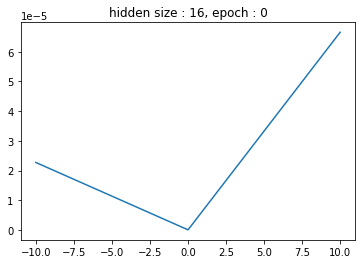

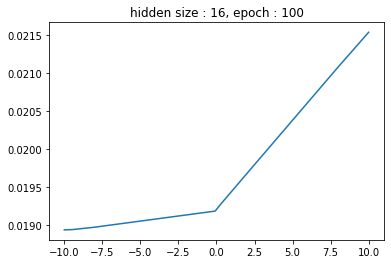

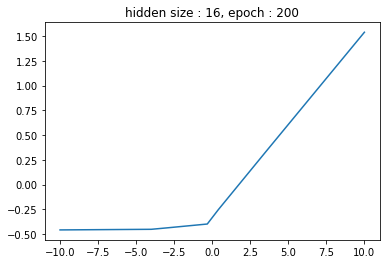

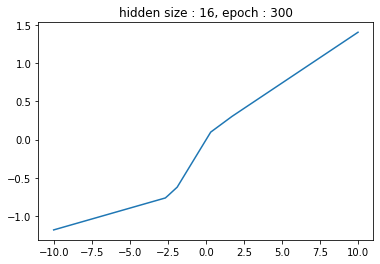

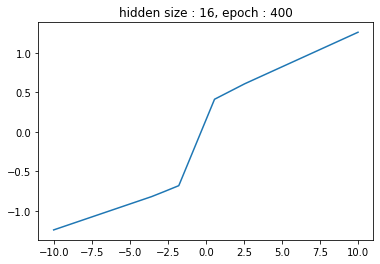

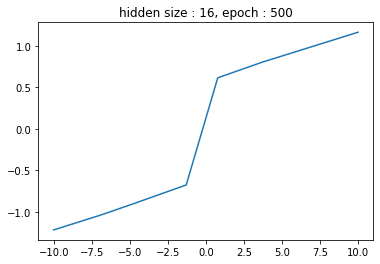

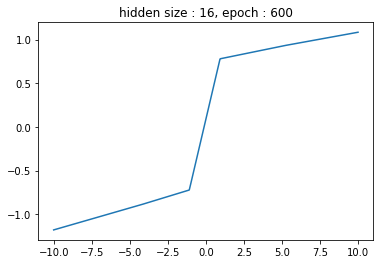

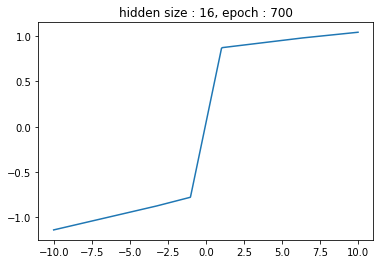

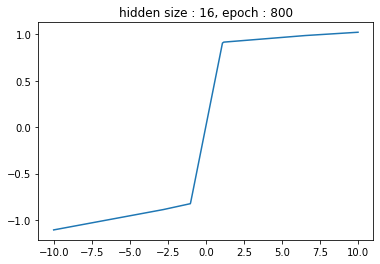

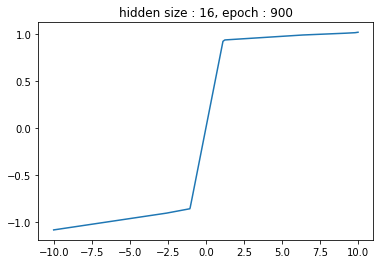

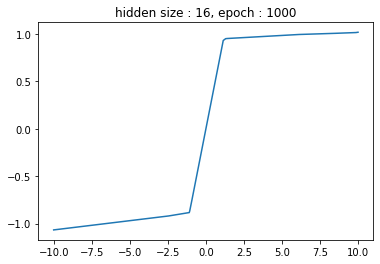

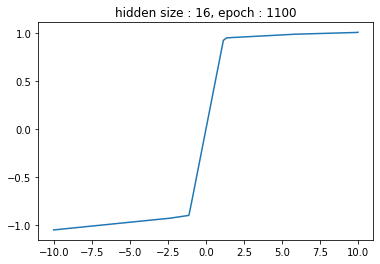

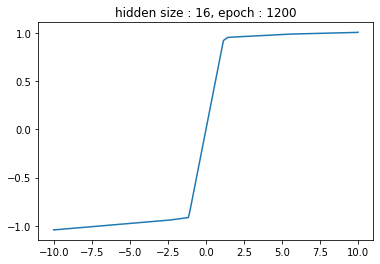

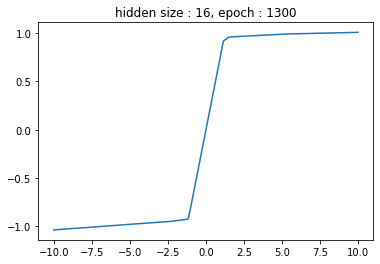

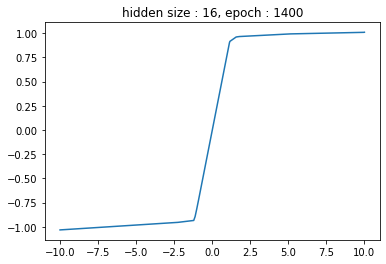

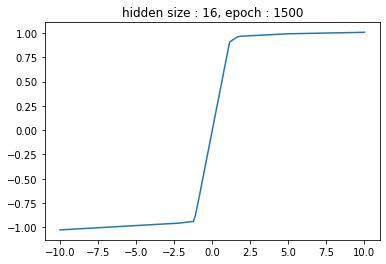

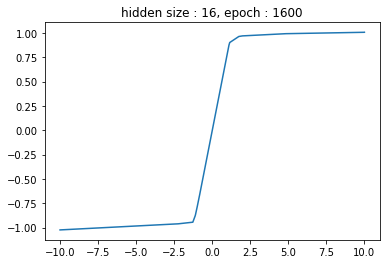

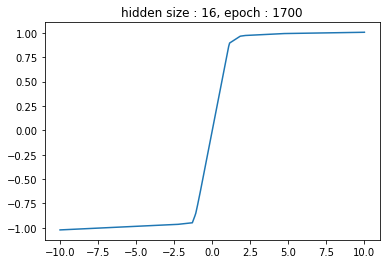

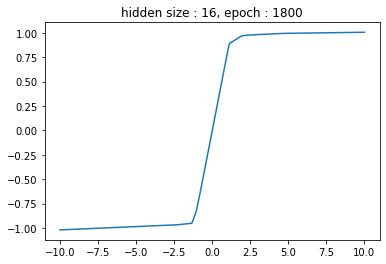

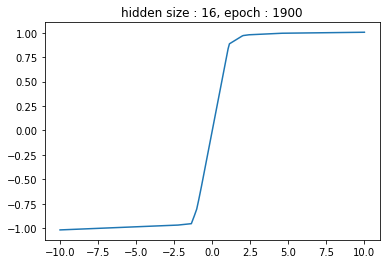

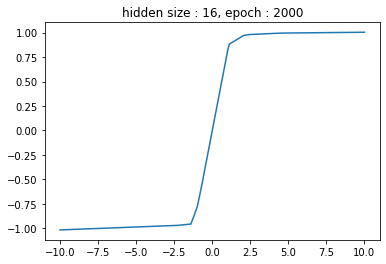

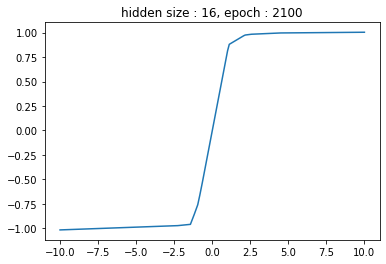

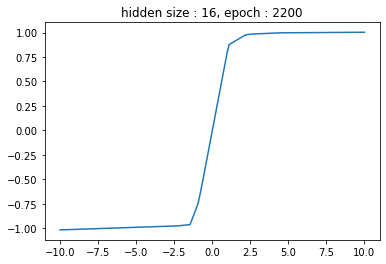

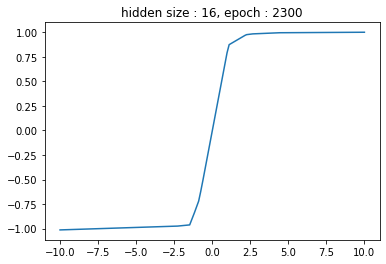

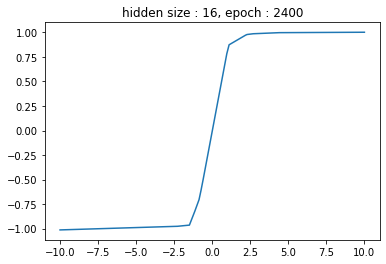

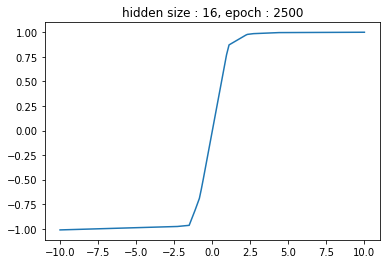

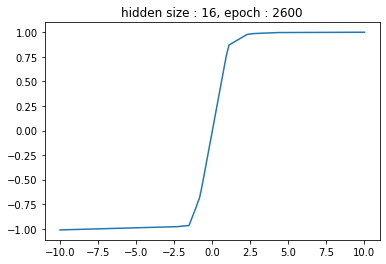

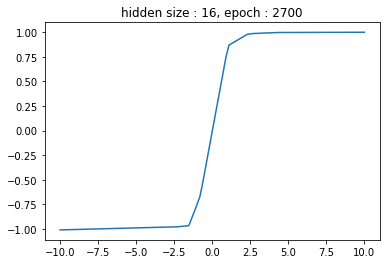

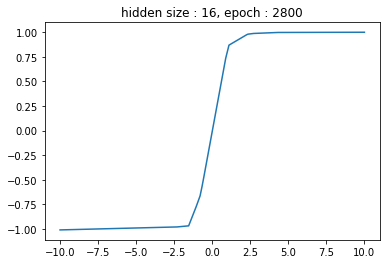

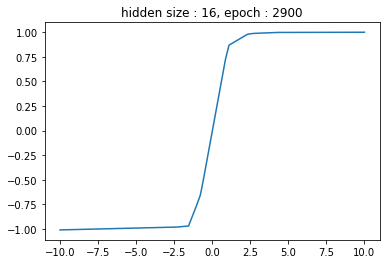

In [24]:
######################################################################
# 문제 1-6 구현한 것을 바탕으로 최종적으로 학습해보세요              #
# 보고서에 그래프를 제출하세요                                       #
######################################################################

hidden_size = 16

network = DNN(input_size=1, hidden_size=hidden_size, output_size=1)

train_size = x_train.shape[0]
batch_size = int(x_train.shape[0]/4)
learning_rate = 0.01

epochs = 3000
step = int(train_size / batch_size)

for epoch in range(epochs):
    if epoch %100 == 0:
        plt.title("hidden size : " + str(hidden_size) +", epoch : " + str(epoch))
        plt.plot(x_train,network.predict(x_train))
        plt.show()

    for batch_idx in range(step):
        x_batch = x_train[batch_idx*batch_size:batch_idx*batch_size+batch_size]
        y_batch = y_train[batch_idx*batch_size:batch_idx*batch_size+batch_size]
        
        grad = network.gradient(x_batch,y_batch)

        for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
            network.params[key] -= learning_rate * grad[key]


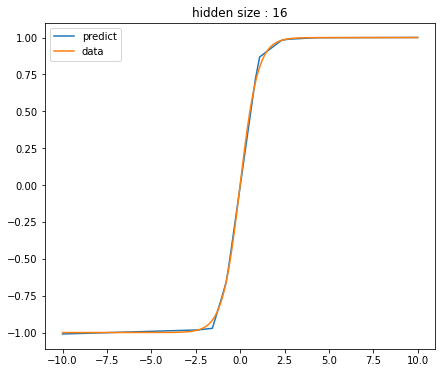

In [25]:
fig = plt.figure(figsize=(7, 6))
plt.title("hidden size : " + str(hidden_size))
plt.plot(x_train,network.predict(x_train), label="predict")
plt.plot(x_train, y_train, label= "data")
plt.legend()
plt.show()
fig.savefig("hidden size " + str(hidden_size) + ".png", dpi=fig.dpi)
